In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('base_diaria_2.xlsx')
df['d'] = pd.to_datetime(df['d'])
df = df.set_index('d')

In [3]:
df.columns

Index(['base', 'reservas', 'base_div_res', 'var_usd_vs_usd_of',
       'circulacion_monetaria', 'depositos', 'prestamos', 'cer', 'tasa_badlar',
       'tasa_pase_pasivas_1_dia', 'inflacion_mensual_oficial',
       'inflacion_esperada_oficial', 'merval_usd', 'sp500', 'vix_index',
       'pasivos_remunerados_total', 'ratio_pasivos_base', 'tasa_badlar.1',
       'ITCRM', 'soja_precio', 'sp500.1', 'SaldoComercial_MM', 'EMAE',
       'cambio_gestion', 'cepo', 'ministro_nombre', 'fmi_desembolso'],
      dtype='object')

In [4]:
#Indice y frecuencia
# exog_cols = [col for col in df.columns if col != 'reservas']
df.index = pd.to_datetime(df.index)


# Asegúrate de que el índice esté ordenado antes de asignar frecuencia
df = df.sort_index()

# Aplicar frecuencia diaria
# 'D' completa los días faltantes con NaN si los hubiera
df = df.asfreq('D')

print(f"Frecuencia del índice: {df.index.freq}")




Frecuencia del índice: <Day>


In [5]:
# --- 2. DEFINICIÓN DE PARTICIONES ---
fin_train = '2017-12-31'
fin_validacion = '2021-12-31'
# Usamos df que contiene las nuevas variables
datos_train = df.loc[:fin_train]
datos_val   = df.loc[fin_train : fin_validacion]
datos_test  = df.loc[fin_validacion :]



In [6]:
# 1. Definimos los grupos de variables
vars_mensuales = [
    'inflacion_mensual_oficial', 'inflacion_esperada_oficial', 
    'EMAE', 'SaldoComercial_MM', 'fmi_desembolso'
]

# El resto son diarias (incluyendo las financieras y monetarias)
vars_diarias = [
    'base', 'reservas', 'base_div_res', 'var_usd_vs_usd_of',
    'circulacion_monetaria', 'depositos', 'prestamos', 'cer', 'tasa_badlar',
    'tasa_pase_pasivas_1_dia', 'merval_usd', 'sp500', 'vix_index',
    'pasivos_remunerados_total', 'ratio_pasivos_base', 'tasa_badlar.1',
    'ITCRM', 'soja_precio', 'sp500.1'
]

# 3. Caso especial: Variables categóricas o de estado (Cepo, Ministro, etc.)
# Generalmente estas también se desfasan 1 día si quieres ver el impacto al día siguiente
vars_estado = ['cambio_gestion', 'cepo', 'ministro_nombre']

# --- PROCESAMIENTO CON PROTECCIÓN DE TARGET ---

# 1. Variables diarias (Protegiendo 'reservas')
for col in vars_diarias:
    df[f'{col}_lag1'] = df[col].shift(1)
    # Solo eliminamos si NO es el target
    if col != 'reservas':
        df.drop(columns=[col], inplace=True)

# 2. Variables mensuales
for col in vars_mensuales:
    serie_mensual = df[col].resample('MS').first()
    serie_lag_mensual = serie_mensual.shift(1)
    df[f'{col}_lag1'] = df.index.to_period('M').map(serie_lag_mensual.to_period('M'))
    df.drop(columns=[col], inplace=True)

# 3. Variables de estado
for col in vars_estado:
    df[f'{col}_lag1'] = df[col].shift(1)
    df.drop(columns=[col], inplace=True)

# Limpieza de nulos iniciales
df.dropna(inplace=True)

print("Estructura de datos lista.")
print(f"Target detectado: {'reservas' in df.columns}")
print(f"Predictores (ejemplos): {[c for c in df.columns if 'lag1' in c][:5]}")

Estructura de datos lista.
Target detectado: True
Predictores (ejemplos): ['base_lag1', 'reservas_lag1', 'base_div_res_lag1', 'var_usd_vs_usd_of_lag1', 'circulacion_monetaria_lag1']


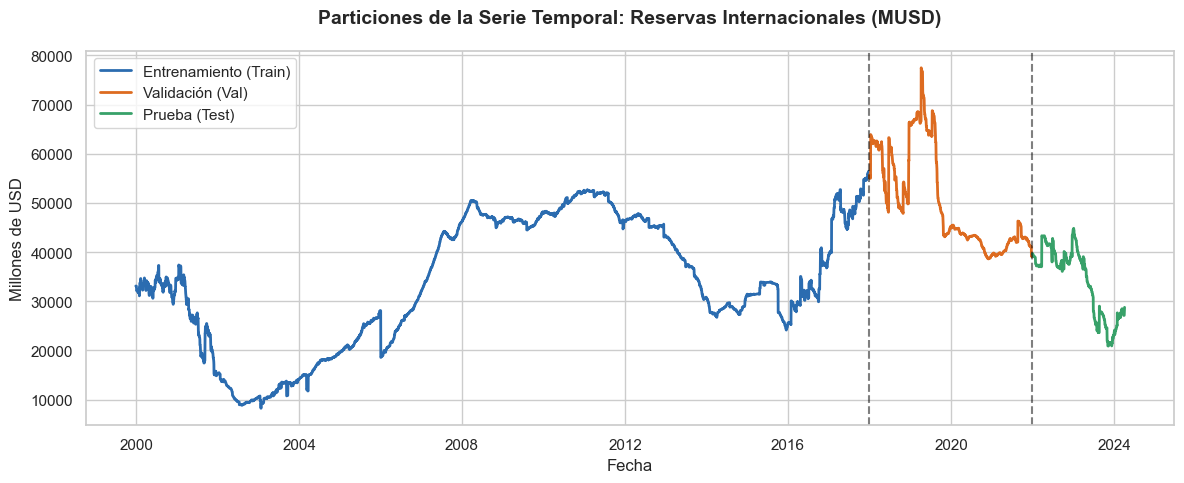

In [7]:

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Graficamos cada segmento
plt.plot(datos_train.index, datos_train['reservas'], label='Entrenamiento (Train)', color='#2b6cb0', linewidth=2)
plt.plot(datos_val.index, datos_val['reservas'], label='Validación (Val)', color='#dd6b20', linewidth=2)
plt.plot(datos_test.index, datos_test['reservas'], label='Prueba (Test)', color='#38a169', linewidth=2)

# Líneas divisorias basadas en la configuración
plt.axvline(pd.to_datetime(fin_train), color='black', linestyle='--', alpha=0.5)
plt.axvline(pd.to_datetime(fin_validacion), color='black', linestyle='--', alpha=0.5)

# Estética
plt.title('Particiones de la Serie Temporal: Reservas Internacionales (MUSD)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Millones de USD', fontsize=12)
plt.legend(frameon=True, loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
# Actualizamos los tamaños para tu configuración de CV
initial_train_size = len(df.loc[:fin_train])
initial_val_size = len(df.loc[:fin_validacion])

⏳ Entrenando SARIMAX (Estructura Lineal)...

--- Resultados del Modelo Estructural ---
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept             0.5676      1.845      0.308      0.758      -3.049       4.184
base_div_res_lag1    15.3109      4.773      3.208      0.001       5.955      24.666
tasa_badlar_lag1     -0.2208     11.474     -0.019      0.985     -22.709      22.268
ar.L1                 0.7873      0.084      9.353      0.000       0.622       0.952
ma.L1                -0.7533      0.094     -7.997      0.000      -0.938      -0.569
sigma2             1.856e+05    363.664    510.403      0.000    1.85e+05    1.86e+05


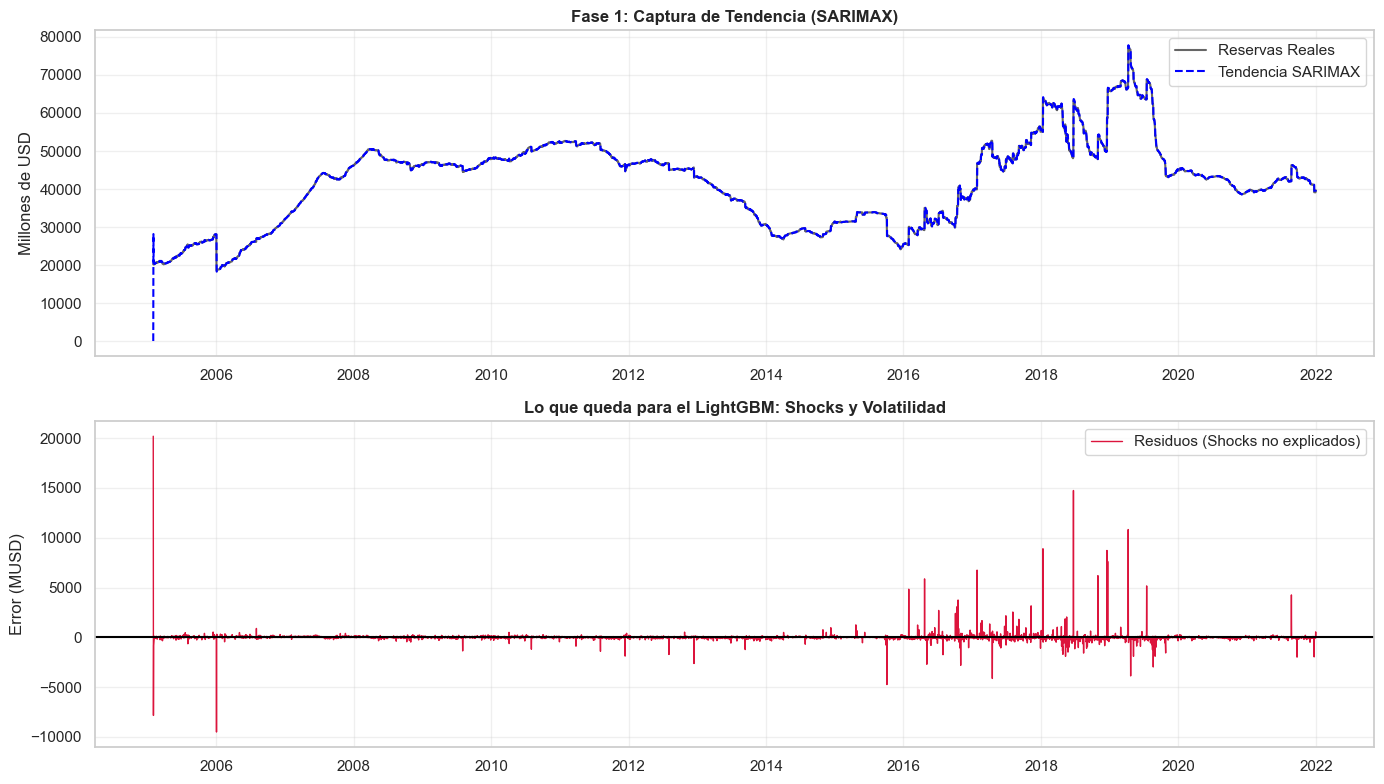


Error Medio Absoluto (MAE) solo con SARIMAX: 99.54 MUSD
Si este número es bajo, el SARIMAX hizo el trabajo sucio. El LightGBM debe bajarlo más.


In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# =============================================================================
# FASE 1: MODELO ESTRUCTURAL (SARIMAX)
# =============================================================================

# 1. Definición de Variables Estructurales
# Estas son las variables "lentas" que explican la tendencia de largo plazo.
# base_div_res_lag1: Es casi una identidad contable del nivel de reservas.
# tasa_badlar_lag1: El costo del dinero (política monetaria base).
cols_sarimax = ['base_div_res_lag1', 'tasa_badlar_lag1']

# Aseguramos que no haya NaNs en el set de entrenamiento para evitar errores de statsmodels
train_mask = (df.index <= fin_validacion)
X_train_sarimax = df.loc[train_mask, cols_sarimax]
y_train_sarimax = df.loc[train_mask, 'reservas']

# 2. Configuración y Entrenamiento
# order=(1,1,1): 
# p=1 (Mira el ayer), d=1 (Diferencia una vez para hacerla estacionaria), q=1 (Media Móvil de errores)
print("⏳ Entrenando SARIMAX (Estructura Lineal)...")

modelo_sarimax = SARIMAX(
    endog = y_train_sarimax,
    exog  = X_train_sarimax,
    order = (1, 1, 1),  
    trend = 'c',        # Incluye constante (drift) para capturar sesgo de tendencia
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_sarimax = modelo_sarimax.fit(disp=False)

# Mostramos los coeficientes para validar económicamente (P>|z| debería ser < 0.05)
print("\n--- Resultados del Modelo Estructural ---")
print(resultado_sarimax.summary().tables[1])

# 3. Generación de Residuos (La "señal" para el LightGBM)
# Predicción dentro de la muestra (fitted values)
prediccion_lineal = resultado_sarimax.fittedvalues

# Calculamos el Residuo: ¿Cuánto se equivocó el modelo clásico?
# Residuo = Valor Real - Explicación Lineal
residuos_train = y_train_sarimax - prediccion_lineal

# ¡IMPORTANTE! Guardamos los residuos en el DataFrame original
# Esta será la variable 'y' (target) para tu LightGBM en el próximo paso
df.loc[residuos_train.index, 'residuos_sarimax'] = residuos_train

# 4. Visualización Diagnóstica
plt.figure(figsize=(14, 8))

# Gráfico A: Nivel Real vs Tendencia Lineal
plt.subplot(2, 1, 1)
plt.plot(y_train_sarimax.index, y_train_sarimax, label='Reservas Reales', color='black', alpha=0.6)
plt.plot(prediccion_lineal.index, prediccion_lineal, label='Tendencia SARIMAX', color='blue', linestyle='--', linewidth=1.5)
plt.title("Fase 1: Captura de Tendencia (SARIMAX)", fontsize=12, fontweight='bold')
plt.ylabel("Millones de USD")
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico B: Los Residuos (Lo que el ML debe predecir)
plt.subplot(2, 1, 2)
plt.plot(residuos_train.index, residuos_train, label='Residuos (Shocks no explicados)', color='crimson', linewidth=1)
plt.axhline(0, color='black', linestyle='-')
plt.title("Lo que queda para el LightGBM: Shocks y Volatilidad", fontsize=12, fontweight='bold')
plt.ylabel("Error (MUSD)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métrica de referencia
mae_lineal = mean_absolute_error(y_train_sarimax, prediccion_lineal)
print(f"\nError Medio Absoluto (MAE) solo con SARIMAX: {mae_lineal:.2f} MUSD")
print("Si este número es bajo, el SARIMAX hizo el trabajo sucio. El LightGBM debe bajarlo más.")

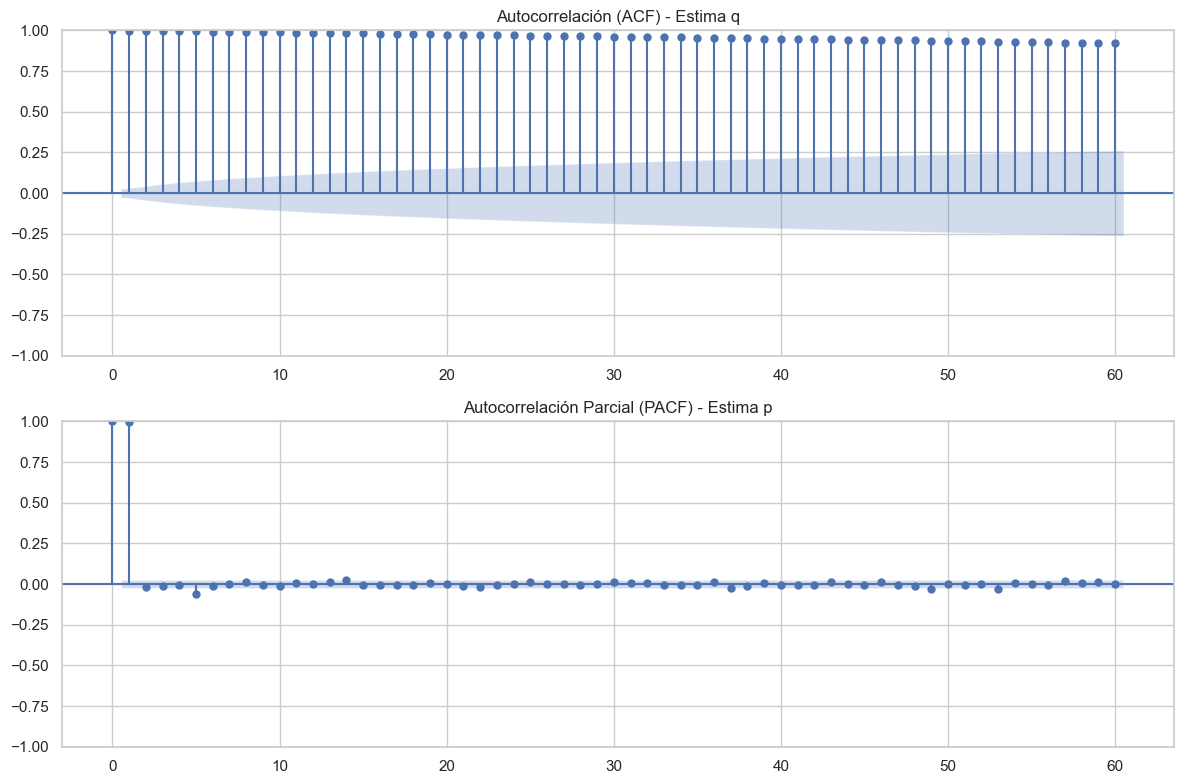

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 1. Preparamos la serie estacionaria (Diferenciada)
# Usamos dropna() porque la diferenciación genera un NaN al inicio
y_diff = df.loc[:fin_validacion, 'reservas'].dropna()

# 2. Graficamos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF: Para estimar 'q' (MA)
plot_acf(y_diff, lags=60, ax=ax1, title="Autocorrelación (ACF) - Estima q")

# PACF: Para estimar 'p' (AR)
plot_pacf(y_diff, lags=60, ax=ax2, title="Autocorrelación Parcial (PACF) - Estima p")

plt.tight_layout()
plt.show()

### 📝 Diagnóstico de Estacionariedad (ACF/PACF)

**Observación Visual:**
* **ACF (Autocorrelación):** Muestra un decaimiento lineal extremadamente lento. Esto indica que la serie tiene una "memoria larga" y **no es estacionaria** en niveles.
* **PACF (Autocorrelación Parcial):** Muestra un pico significativo solo en el Lag 1 y luego se corta abruptamente.

**Conclusión:**
Este comportamiento es característico de un proceso AR(1) con raíz unitaria.
> *Decisión Metodológica:* Se confirma la necesidad de aplicar **Primera Diferencia (d=1)** en el modelado ARIMA para evitar resultados espurios.

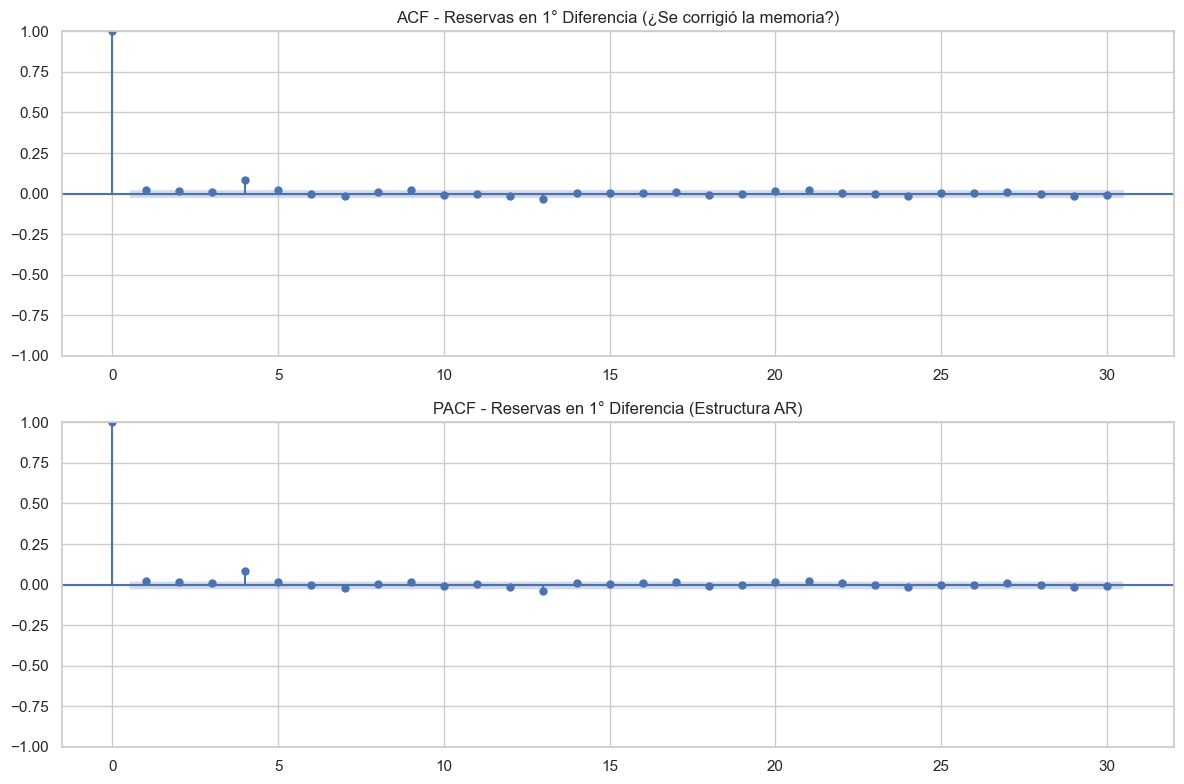

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Aplicamos la medicina: Primera Diferencia
# Usamos dropna() porque el primer dato se pierde al diferenciar
y_diff = df.loc[:fin_validacion, 'reservas'].diff().dropna()

# 2. Graficamos el resultado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF (Autocorrelación) sobre Diferencias
plot_acf(y_diff, lags=30, ax=ax1, title="ACF - Reservas en 1° Diferencia (¿Se corrigió la memoria?)")

# PACF (Parcial) sobre Diferencias
plot_pacf(y_diff, lags=30, ax=ax2, title="PACF - Reservas en 1° Diferencia (Estructura AR)")

plt.tight_layout()
plt.show()

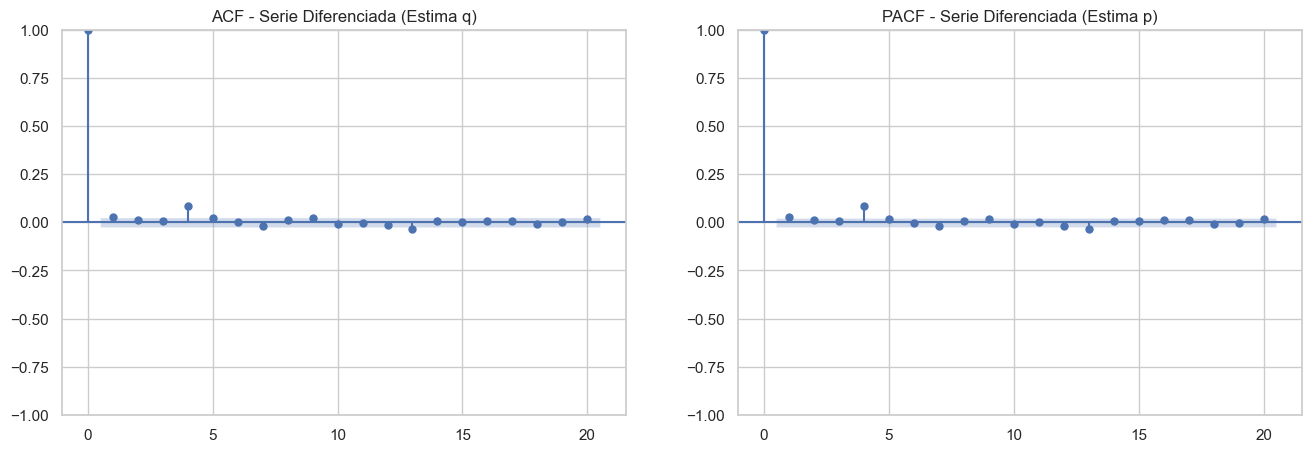

⚙️ Entrenando ARIMA(1,1,1) Univariado...


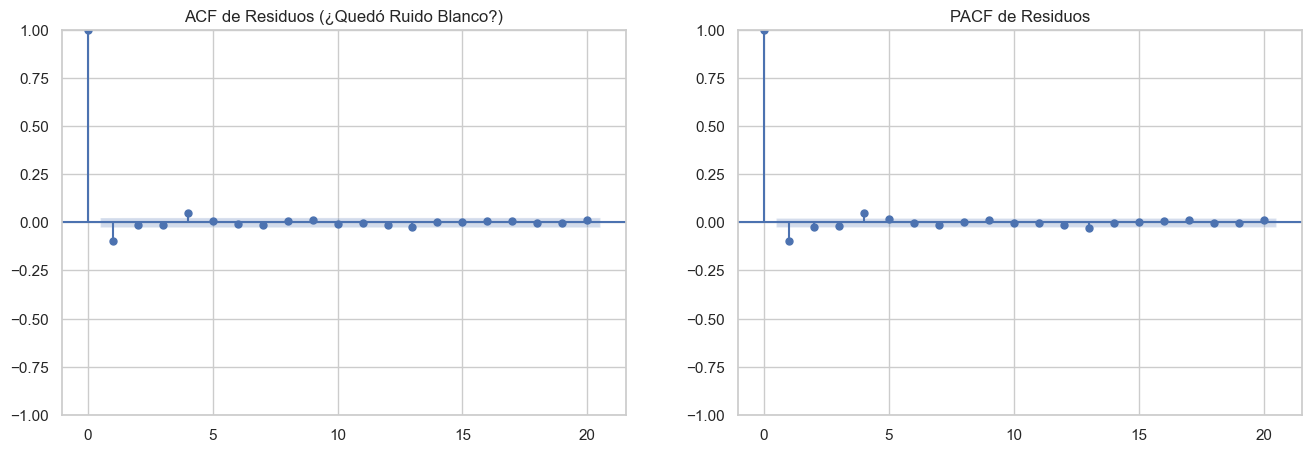


📊 RESULTADOS ARIMA(1,1,1) PURO
------------------------------
AIC: 92442.79
BIC: 92469.70
------------------------------
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0079      2.432      1.237      0.216      -1.758       7.774
ar.L1          0.7333      0.083      8.865      0.000       0.571       0.895
ma.L1         -0.7003      0.092     -7.592      0.000      -0.881      -0.519
sigma2      1.858e+05    301.749    615.872      0.000    1.85e+05    1.86e+05


In [25]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# =============================================================================
# 1. DIAGNÓSTICO PREVIO (ACF y PACF de la Serie Diferenciada)
# =============================================================================
# Esto nos dice qué ARIMA necesitamos.
# Diferenciamos una vez (d=1) porque sabemos que tiene tendencia.

y_diff = df.loc[:fin_validacion, 'reservas'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# ACF: Nos ayuda a elegir 'q' (Media Móvil)
plot_acf(y_diff, lags=20, ax=ax1, title="ACF - Serie Diferenciada (Estima q)")
# PACF: Nos ayuda a elegir 'p' (Autoregresivo)
plot_pacf(y_diff, lags=20, ax=ax2, title="PACF - Serie Diferenciada (Estima p)")

plt.show()

# =============================================================================
# 2. ENTRENAMIENTO ARIMA(1, 1, 1) PURO (Sin Exógenas)
# =============================================================================
# Probamos el clásico (1,1,1) como punto de partida base.

print("⚙️ Entrenando ARIMA(1,1,1) Univariado...")

# Nota: No pasamos 'exog'. Solo la serie 'reservas'.
model_arima = SARIMAX(
    endog = df.loc[:fin_validacion, 'reservas'], 
    order = (1, 1, 1), 
    trend = 'c', # Drift (constante)
    enforce_stationarity=False, 
    enforce_invertibility=False
)

result_arima = model_arima.fit(disp=False)

# =============================================================================
# 3. DIAGNÓSTICO DE RESIDUOS Y MÉTRICAS
# =============================================================================

# Graficamos ACF y PACF de los residuos para ver si quedó "limpio"
residuos = result_arima.resid

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(residuos, lags=20, ax=ax3, title="ACF de Residuos (¿Quedó Ruido Blanco?)")
plot_pacf(residuos, lags=20, ax=ax4, title="PACF de Residuos")
plt.show()

# Imprimimos las métricas clave
print("\n📊 RESULTADOS ARIMA(1,1,1) PURO")
print("-" * 30)
print(f"AIC: {result_arima.aic:.2f}")
print(f"BIC: {result_arima.bic:.2f}")
print("-" * 30)
print(result_arima.summary().tables[1])

🤖 Iniciando búsqueda automática de parámetros...
Buscando hasta orden 5 para capturar ese 'Lag 4' rebelde...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=92466.264, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92478.290, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92476.332, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=92476.433, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92476.620, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=92467.813, Time=1.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=92467.780, Time=1.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=92477.518, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=92477.328, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=92467.210, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=92464.499, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=92474.744, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92

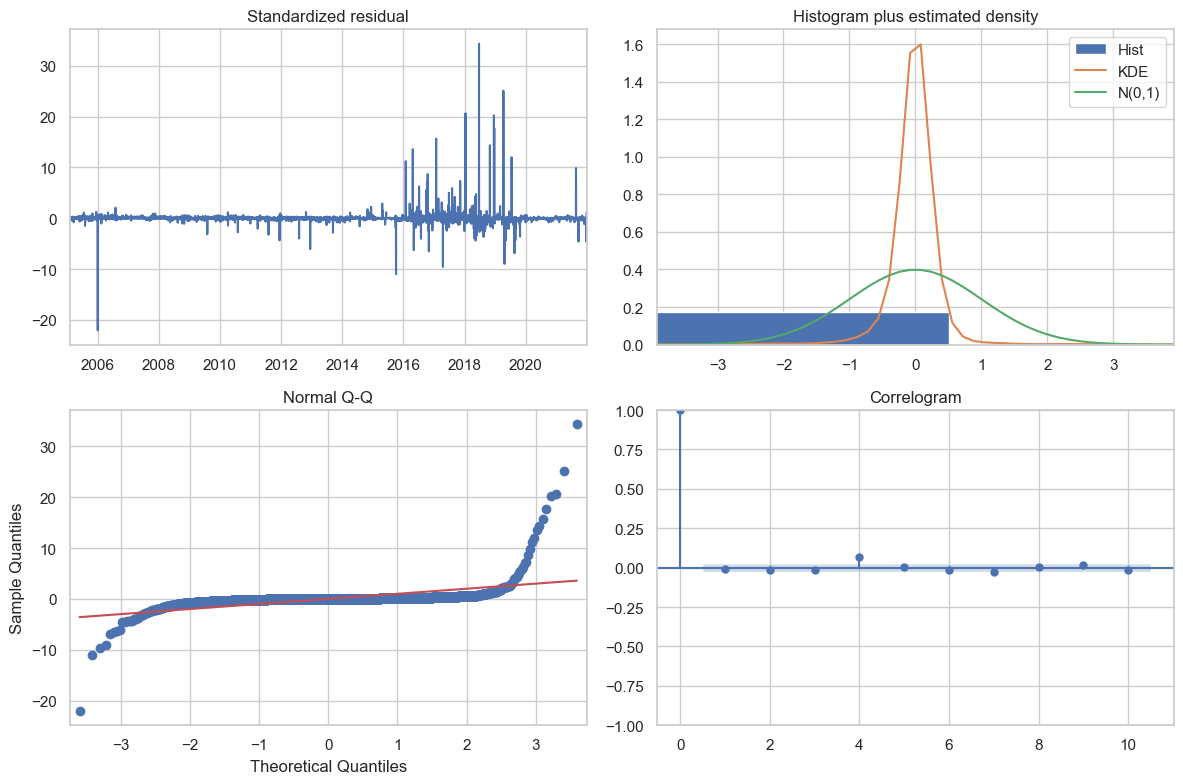

In [28]:
import pmdarima as pm
import matplotlib.pyplot as plt

# =============================================================================
# AUTOARIMA UNIVARIADO (Sin Exógenas)
# =============================================================================
# Objetivo: Encontrar el (p,d,q) que minimice el AIC y limpie los residuos.

# 1. Preparamos los datos
mask = (df.index <= fin_validacion)
y_train = df.loc[mask, 'reservas']

print("🤖 Iniciando búsqueda automática de parámetros...")
print("Buscando hasta orden 5 para capturar ese 'Lag 4' rebelde...")

modelo_auto = pm.auto_arima(
    y = y_train,
    start_p=1, start_q=1,
    max_p=6, max_q=6,       # Subimos el límite para dejarlo explorar
    d=1,                    # Ya confirmamos que necesita 1 diferencia
    seasonal=False,         # Mantenemos simple por ahora
    stepwise=True,          # Algoritmo rápido (Hyndman-Khandakar)
    information_criterion='aic',
    trace=True,             # Para ver qué va probando
    error_action='ignore',
    suppress_warnings=True
)

print("\n🏆 MEJOR MODELO GANADOR:")
print(modelo_auto.summary())

# =============================================================================
# DIAGNÓSTICO FINAL DEL GANADOR
# =============================================================================
print("\n📊 Generando diagnósticos del mejor modelo...")
modelo_auto.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

--- Diagnóstico de los Residuos ---
Media (Debería ser ~0): 5.9079
Skewness (Sesgo): 18.6892 (Ideal: 0)
Kurtosis (Curtosis): 663.2603 (Ideal: 3 para Normal)


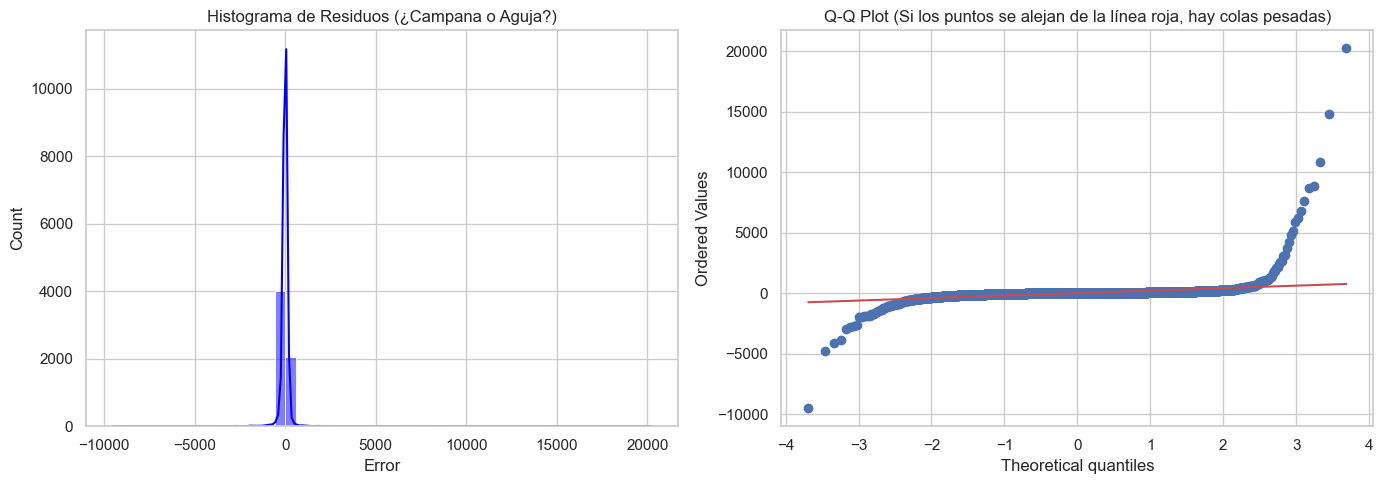

In [29]:
from scipy import stats
import seaborn as sns

# Residuos del mejor modelo AutoARIMA
residuos = modelo_auto.resid()

# 1. Estadísticas Descriptivas
print("--- Diagnóstico de los Residuos ---")
print(f"Media (Debería ser ~0): {residuos.mean():.4f}")
print(f"Skewness (Sesgo): {stats.skew(residuos):.4f} (Ideal: 0)")
print(f"Kurtosis (Curtosis): {stats.kurtosis(residuos):.4f} (Ideal: 3 para Normal)")

# Si la Kurtosis es > 3, tenés "Colas Pesadas" (Muchos shocks extremos)

# 2. Visualización Mejorada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histograma con Curva de Densidad (KDE)
sns.histplot(residuos, kde=True, ax=ax1, color='blue', bins=50)
ax1.set_title("Histograma de Residuos (¿Campana o Aguja?)")
ax1.set_xlabel("Error")

# Q-Q Plot (Para ver qué tanto se desvía de la normalidad)
stats.probplot(residuos, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot (Si los puntos se alejan de la línea roja, hay colas pesadas)")

plt.tight_layout()
plt.show()